In [50]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

File ‘airline_passengers.csv’ already there; not retrieving.



In [51]:
import pandas as pd
import numpy as np

In [52]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [53]:
df.isna().sum()

Passengers    0
dtype: int64

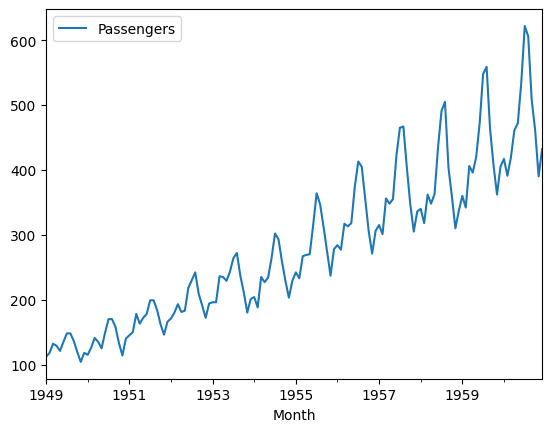

In [54]:
df.plot();

In [55]:
alpha = 0.2

In [56]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [57]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

<Axes: xlabel='Month'>

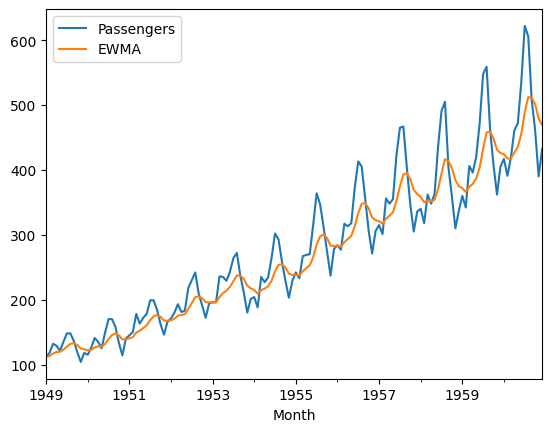

In [58]:
df.plot()

In [59]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
  if len(manual_ewma) > 0:
    xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)
df['Manual'] = manual_ewma

<Axes: xlabel='Month'>

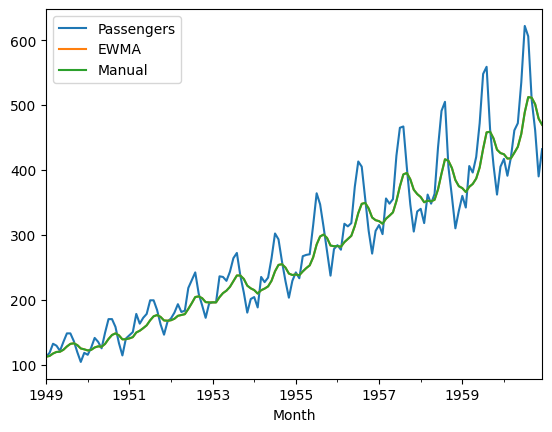

In [60]:
df.plot()

In [61]:
df.head()

,Passengers,EWMA,Manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [62]:
df.drop('Manual', axis=1, inplace=True)

In [63]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [64]:
ses = SimpleExpSmoothing(df['Passengers'])

/Users/jmahe/projects/python/finance/jupyter-m4/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [65]:
# link to offset aliases docs
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [66]:
df.index.freq = 'MS'

In [67]:
ses = SimpleExpSmoothing(df['Passengers'])

In [68]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [69]:
res

In [70]:
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [71]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [72]:
df

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,113.200000,112.000000
1949-03-01,132,116.960000,113.200000
1949-04-01,129,119.368000,116.960000
1949-05-01,121,119.694400,119.368000
...,...,...,...
1960-08-01,606,512.214093,488.767616
1960-09-01,508,511.371274,512.214093
1960-10-01,461,501.297019,511.371274


In [73]:
np.allclose(df['SES'], res.fittedvalues)

True

<Axes: xlabel='Month'>

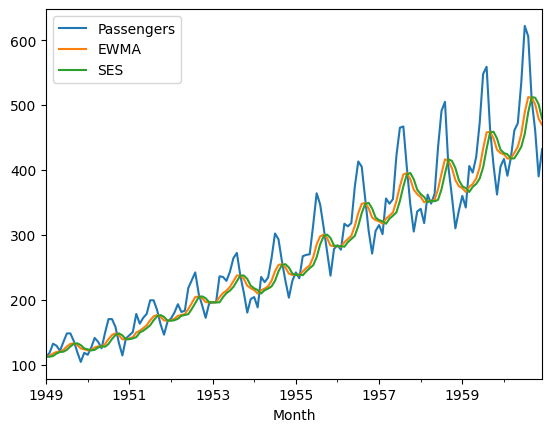

In [74]:
df.plot()

In [75]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [76]:
df['SES-1'] = df['SES'].shift(-1)

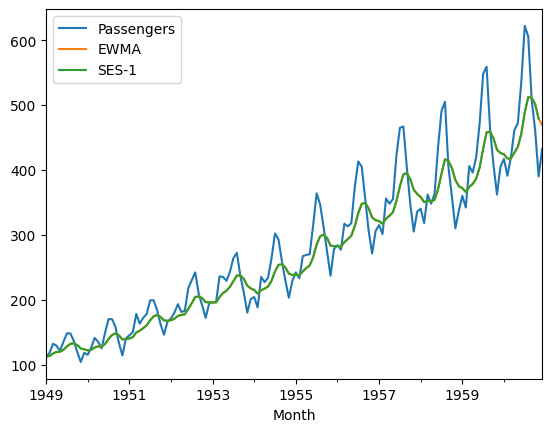

In [77]:
### No!
df[['Passengers', 'EWMA', 'SES-1']].plot();

In [78]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [79]:
ses = SimpleExpSmoothing(train['Passengers'])
res = ses.fit()

In [80]:
res.fittedvalues

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    118.000000
1949-04-01    132.000000
1949-05-01    129.000000
                 ...    
1959-08-01    547.999999
1959-09-01    559.000000
1959-10-01    463.000001
1959-11-01    407.000001
1959-12-01    362.000001
Freq: MS, Length: 132, dtype: float64

In [81]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

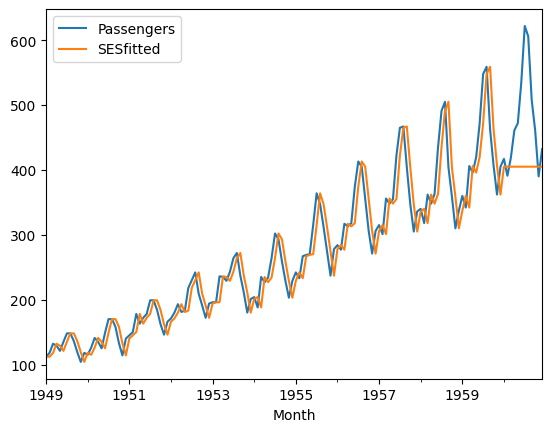

In [82]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot();

In [83]:
res.params

{'smoothing_level': np.float64(0.9999999850988388),
 'smoothing_trend': np.float64(nan),
 'smoothing_seasonal': np.float64(nan),
 'damping_trend': nan,
 'initial_level': np.float64(112.0),
 'initial_trend': np.float64(nan),
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [84]:
from statsmodels.tsa.holtwinters import Holt

In [85]:
holt = Holt(df['Passengers'])

In [86]:
res_h = holt.fit()

In [87]:
df['Holt'] = res_h.fittedvalues

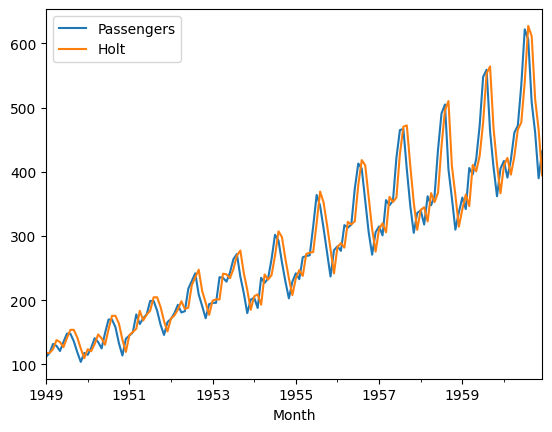

In [88]:
df[['Passengers', 'Holt']].plot();

In [89]:
holt = Holt(train['Passengers'])
res_h = holt.fit()
df.loc[train_idx, 'Holt'] = res_h.fittedvalues

In [90]:
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)

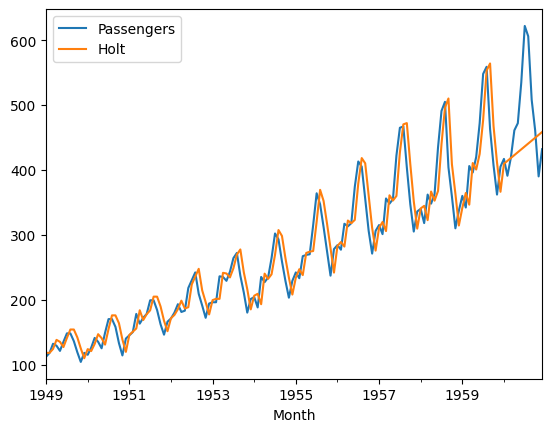

In [91]:
df[['Passengers', 'Holt']].plot();

In [92]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [93]:
hw = ExponentialSmoothing(train['Passengers'], \
                          trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

In [94]:
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues

In [95]:
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

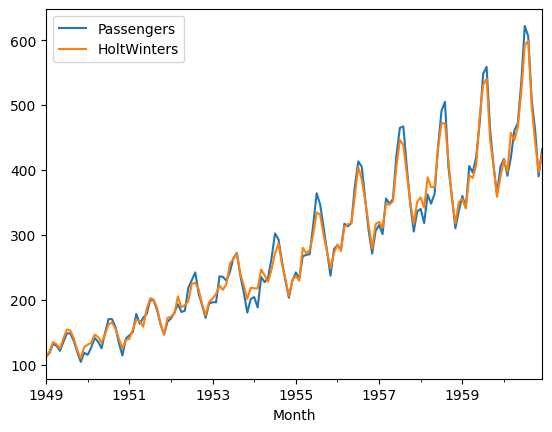

In [96]:
df[['Passengers', 'HoltWinters']].plot();

In [97]:
def rmse(y, t):
  return np.sqrt(np.mean((y - t)**2))

In [98]:
def mae(y, t):
  return np.mean(np.abs(y - t))

In [99]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.624688041643962
Test RMSE: 16.980953135609667


In [100]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 9.008470122605447
Test MAE: 13.381971356937669


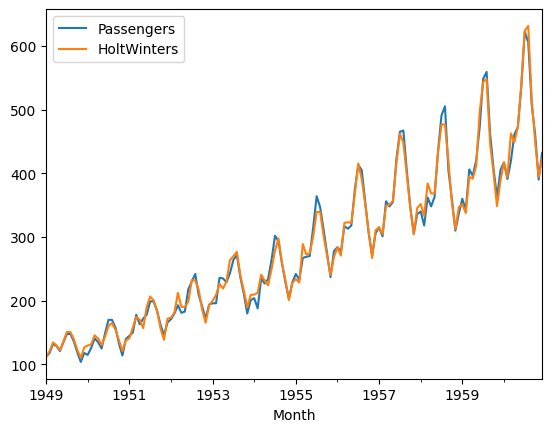

In [101]:
hw = ExponentialSmoothing(train['Passengers'], \
                          trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [102]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.767995194379747
Test RMSE: 15.81038122043562


In [103]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.604244195390459
Test MAE: 10.303143852657163


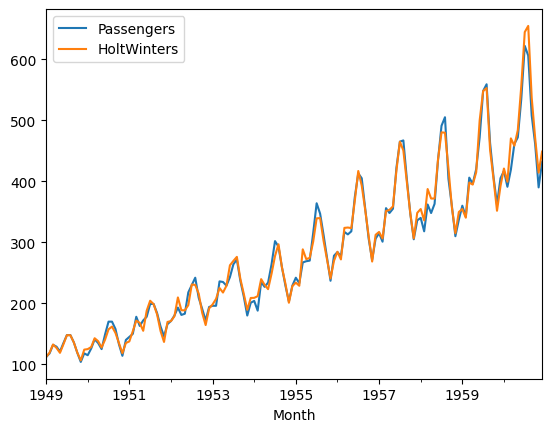

In [104]:
hw = ExponentialSmoothing(train['Passengers'], \
                          trend='mul', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [105]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.617925036951766
Test RMSE: 25.809816019241286


In [106]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.112228572505322
Test MAE: 20.84774448528377
